# Rice Classification with NN (using CUDA)


dataset contains 75000 images from 5 diffrent type of rices :

1. Arborio
2. Basmati
3. Ipsala
4. Jasmine
5. Karacadag

15000 images for each class of rice

dataset : https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

### choosing device

In [14]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


### creating dataset class


In [15]:
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
from math import floor
from torchvision.transforms import Grayscale,Resize


labelsDict = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag"
}

class Custom_Dataset(Dataset):
    def __init__(self,labels ,img_dir,transform=None):
        self.labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # label = labelsDict[floor(idx/15000)]
        label = self.labels[idx]
        label = label.to(device)
        img_name = labelsDict[int(label)]+" (" + str(idx -(15000*floor(idx/15000))+1) +").jpg"
        img_path = os.path.join(os.getcwd(),self.img_dir, img_name)
        image = read_image(img_path)
        # label = int(label.item())
        image = Grayscale()(image) #remove 3 image channels
        image = Resize(size=(50,50),antialias=True)(image)
        image = image.squeeze()
        image = image.float()
        image = image.to(device)
        if(self.transform):
            image = self.transform(image)
        return image, label
    


### creating our dataset

In [16]:
labels = torch.zeros(75000)
labels[15000:30000] = 1
labels[30000:45000] = 2
labels[45000:60000] = 3
labels[60000:75000] = 4

dataset = Custom_Dataset(labels,"Rice_Image_Dataset")

### testing dataset

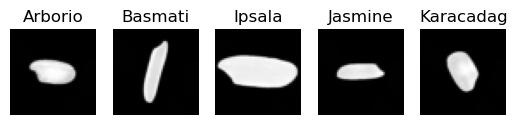

In [17]:
import matplotlib.pyplot as plt

testData = [0,15000,30000,45000,60000]
fig,ax = plt.subplots(1,5)
for i in range(len(testData)):
    img, label = dataset[testData[i]]
    ax[i].imshow(img.cpu(),cmap="gray")
    ax[i].set_title(labelsDict[label.item()])
    ax[i].axis("off")
plt.show()


### shuffeling and creating train / test dataset

In [18]:
from torch.utils.data import Subset
import numpy as np

N = len(dataset)

indices = np.arange(N)
indices = np.random.permutation(indices)

slice = int(0.8*N)

train_indices = indices[:slice]
test_indices = indices[slice:]

train_dataset = Subset(dataset,train_indices)
test_dataset = Subset(dataset,test_indices)


### Loading Data

In [19]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=64,shuffle=True)


### test dataloader

shape : torch.Size([50, 50])


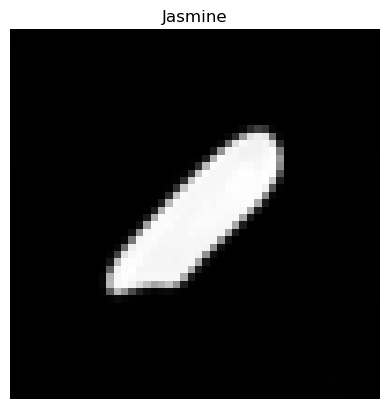

In [20]:
testData = next(iter(train_dataloader))
print("shape :",testData[0][0].shape)
plt.imshow(testData[0][0].cpu(),cmap="gray")
plt.axis('off')
plt.title(labelsDict[testData[1][0].item()])
plt.show()

### creating model

In [21]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.seq = nn.Sequential(
            nn.Linear(50*50,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,5)
        ) 
        
    def forward(self,X):
        X = self.flatten(X)
        logits = self.seq(X)
        return logits

### learning

In [23]:
model = NeuralNetwork().to(device)

learning_rate = 1e-3
epoches = 5
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

def train_loop(train_dataloader,model,loss_fn,optim):
    model.train()
    for batch, (X,y) in enumerate(train_dataloader):
        y=y.to(torch.int64)
        pred = model(X)
        loss = loss_fn(pred,y)

        loss.backward()
        optim.step()
        optim.zero_grad()

        if (batch % 100 == 0):
            loss = loss.item()
            current = (batch+1)*len(X)
            total_size = len(train_dataloader.dataset)
            print("loss : {} / [{}/{}]".format(loss,current,total_size))

def test_loop(test_dataloader,model,loss_fn):
    model.eval()
    test_loss,correct = 0,0

    with torch.no_grad():
        for X,y in test_dataloader:
            y=y.to(torch.int64)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    correct /= size # acuuracy
    test_loss /= num_batches # avg loss in each batch

    print("Test ERR >> Acc : {} / Avg Loss : {}".format(correct,test_loss))
    return correct

finalAcc = -100

for i in range(epoches):
    print("EPOTCH {} -----------------------------".format(i+1))
    train_loop(train_dataloader,model,loss_fn,optimizer)
    acc = test_loop(test_dataloader,model,loss_fn)
    finalAcc = acc

print("Done, Accuracy is : {}".format(finalAcc))


EPOTCH 1 -----------------------------
loss : 7.709244728088379 / [64/60000]
loss : 0.162395179271698 / [6464/60000]
loss : 0.14177313446998596 / [12864/60000]
loss : 0.15966291725635529 / [19264/60000]
loss : 0.05044935643672943 / [25664/60000]
loss : 0.09630768746137619 / [32064/60000]
loss : 0.1943528950214386 / [38464/60000]
loss : 0.16869765520095825 / [44864/60000]
loss : 0.22276069223880768 / [51264/60000]
loss : 0.04776471480727196 / [57664/60000]
Test ERR >> Acc : 0.9447333333333333 / Avg Loss : 0.15988750941258795
EPOTCH 2 -----------------------------
loss : 0.08699164539575577 / [64/60000]
loss : 0.04353124648332596 / [6464/60000]
loss : 0.11728403717279434 / [12864/60000]
loss : 0.04728078842163086 / [19264/60000]
loss : 0.2449236661195755 / [25664/60000]
loss : 0.07263775169849396 / [32064/60000]
loss : 0.13888320326805115 / [38464/60000]
loss : 0.14290690422058105 / [44864/60000]
loss : 0.10503929108381271 / [51264/60000]
loss : 0.03943176567554474 / [57664/60000]
Test E

after around **10m**(using cuda) resulted with accuracy **97%**<br>
afer epoch 2 the accuracy change is not so huge 